In [ ]:
# Install these required libraries
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install datasets
!pip install -q monai

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-32n8odyf
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-32n8odyf
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=ecf9524fb57bae7bddfef023706b3ece47f0d9e1fa4c1f0d87ff8b82f783430a
  Stored in directory: /tmp/pip-ephem-wheel-cache-9kw1x_ca/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 534.5/534.5 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 7

In [ ]:
import os, glob, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import cv2
from torch.utils.data import Dataset, DataLoader
from transformers import SamProcessor, SamModel
import monai
from tqdm import tqdm
from statistics import mean
from sklearn.model_selection import train_test_split
from segment_anything import sam_model_registry

<frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.


Load data into numpy arrays. Here we are importing a tiff stack containing 165 images of size 768x1024. You can use glob to import multiple images from a directory or any other method. The goal is to end up with a numpy array for images and an array for masks.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ROOT = "/content/drive/MyDrive/Kuliah/Skripsi S1"
IMAGES_DIR = os.path.join(ROOT, "train/images")
MASKS_DIR  = os.path.join(ROOT, "train/targets")
SAVE_DIR = os.path.join(ROOT, "checkpoints")
CACHE = os.path.join(ROOT, "cache")
os.makedirs(CACHE, exist_ok=True)
print('Device:', DEVICE)


pre_imgs = sorted(glob.glob(os.path.join(IMAGES_DIR, "*_pre_disaster.png")))
print("Found PRE images:", len(pre_imgs))

pairs = []
for ip in pre_imgs:
    base = os.path.basename(ip)
    mask_name = base.replace("_pre_disaster.png", "_pre_disaster_target.png")
    mp = os.path.join(MASKS_DIR, mask_name)
    if os.path.exists(mp):
        pairs.append((ip, mp))

print("Paired (img,mask):", len(pairs))

Device: cuda
Found PRE images: 2799
Paired (img,mask): 2799


In [9]:
if len(pairs) > 0:
    ip, mp = random.choice(pairs)
    print("Sample pair:", os.path.basename(ip), "with", os.path.basename(mp))


Sample pair: santa-rosa-wildfire_00000175_pre_disaster.png with santa-rosa-wildfire_00000175_pre_disaster_target.png


In [ ]:
def one_image_box(gt):
    gt = (gt > 0).astype(np.uint8)
    if gt.sum() == 0:
        return None

    ys, xs = np.where(gt > 0)
    x0, x1 = xs.min(), xs.max()
    y0, y1 = ys.min(), ys.max()

    return [int(x0), int(y0), int(x1), int(y1)]

In [ ]:
class XBDForSAM(Dataset):
    def __init__(self, pairs, processor, skip_empty=True):
        self.samples = pairs
        self.processor = processor
        self.skip_empty = skip_empty

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        ip, mp = self.samples[idx]
        image = Image.open(ip).convert("RGB")
        mask  = Image.open(mp).convert("L")
        gt    = (np.array(mask) > 0).astype(np.uint8)

        bbox = one_image_box(gt)

        if bbox is None:
            if self.skip_empty:
                new_idx = np.random.randint(len(self.samples))
                return self.__getitem__(new_idx)
            bbox = [0, 0, 1, 1]

        x0, y0, x1, y1 = map(float, bbox)
        input_boxes = [[[x0, y0, x1, y1]]]

        inputs = self.processor(image, input_boxes=input_boxes, return_tensors="pt")
        inputs = {k: v.squeeze(0) for k,v in inputs.items()}
        inputs["ground_truth_mask"] = gt.astype(np.uint8)
        return inputs

## SANITY CHECK

In [ ]:
def visualize_bbox(image, mask, bbox, title):
    plt.figure(figsize=(12, 4))

    # --- Image ---
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis("off")

    if bbox is not None:
        x0, y0, x1, y1 = bbox
        plt.gca().add_patch(
            plt.Rectangle(
                (x0, y0), x1 - x0, y1 - y0,
                edgecolor="red", facecolor="none", lw=2
            )
        )

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap="gray")
    plt.title(title)
    plt.axis("off")

    if bbox is not None:
        plt.gca().add_patch(
            plt.Rectangle(
                (x0, y0), x1 - x0, y1 - y0,
                edgecolor="red", facecolor="none", lw=2
            )
        )

    plt.show()


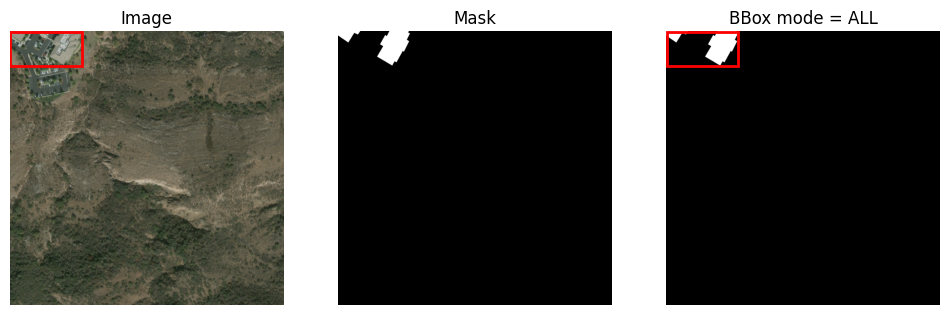

In [28]:
img_path, gt_path = random.choice(pairs)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
gt = (gt > 0).astype(np.uint8)

bbox_all = one_image_box(gt, mode="all")
visualize_bbox(img, gt, bbox_all, title="BBox mode = ALL")


## End of sanity check

In [ ]:
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
def collate_fn(batch):
    out = {}
    for k in batch[0].keys():
        if k == "ground_truth_mask":
            ms = [torch.from_numpy(b[k]).to(torch.uint8) for b in batch]
            out[k] = torch.stack(ms, dim=0).float()
        else:
            out[k] = torch.stack([b[k] for b in batch], dim=0)
    return out

train_pairs, val_pairs = train_test_split(pairs, test_size=0.1, random_state=42)

train_ds = XBDForSAM(train_pairs, processor)
val_ds   = XBDForSAM(val_pairs, processor)

train_dataloader = DataLoader(
    train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    collate_fn=collate_fn
)

val_dataloader = DataLoader(
    val_ds,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    collate_fn=collate_fn
)


# sanity check 1 batch
b = next(iter(train_dataloader))
print(b["input_boxes"].shape, b["ground_truth_mask"].shape)
for k,v in b.items():
    print(k, tuple(v.shape))
b = next(iter(val_dataloader))
for k,v in b.items():
    print(k, tuple(v.shape))



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

torch.Size([2, 1, 4]) torch.Size([2, 1024, 1024])
pixel_values (2, 3, 1024, 1024)
original_sizes (2, 2)
reshaped_input_sizes (2, 2)
input_boxes (2, 1, 4)
ground_truth_mask (2, 1024, 1024)
pixel_values (2, 3, 1024, 1024)
original_sizes (2, 2)
reshaped_input_sizes (2, 2)
input_boxes (2, 1, 4)
ground_truth_mask (2, 1024, 1024)


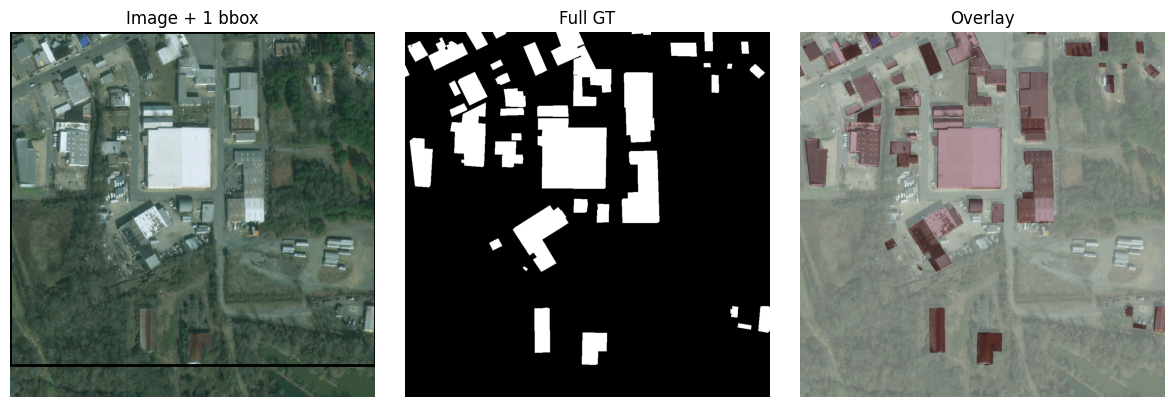

In [ ]:
idx = 8
s = val_ds[idx]
img = s["pixel_values"].permute(1,2,0).numpy()
img = (img - img.min())/(img.max()-img.min() + 1e-6)
x0,y0,x1,y1 = s["input_boxes"][0].tolist()
gt = s["ground_truth_mask"]

import matplotlib.pyplot as plt, matplotlib.patches as mpatches
plt.figure(figsize=(12,4))
ax = plt.subplot(1,3,1); ax.imshow(img); ax.axis('off'); ax.set_title("Image + 1 bbox")
ax.add_patch(mpatches.Rectangle((x0,y0), x1-x0, y1-y0, fill=False, linewidth=2))
plt.subplot(1,3,2); plt.imshow(gt, cmap='gray'); plt.title("Full GT"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(img); plt.imshow(gt, cmap='Reds', alpha=0.35); plt.title("Overlay"); plt.axis('off')
plt.tight_layout(); plt.show()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry["vit_b"](
    checkpoint=os.path.join(SAVE_DIR, "sam_vit_b_01ec64.pth")
)
sam.to(device)

for p in sam.image_encoder.parameters():
    p.requires_grad = False
for p in sam.prompt_encoder.parameters():
    p.requires_grad = False

optimizer = torch.optim.Adam(
    sam.mask_decoder.parameters(), lr=1e-5
)

seg_loss = monai.losses.DiceCELoss(
    sigmoid=True, squared_pred=True, reduction="mean"
)


In [ ]:
num_epochs = 10
best_val_dice = -1.0

os.makedirs(SAVE_DIR, exist_ok=True)
best_path = f"{SAVE_DIR}/SAM_1bbox_zr_best.pt"
last_path = f"{SAVE_DIR}/SAM_1bbox_zr_last.pt"

In [ ]:
def dice_at_05(pred_logits, gt):  # pred_logits: [B,H,W], gt: [B,H,W]
    prob  = torch.sigmoid(pred_logits)
    pred  = (prob > 0.5).float()
    inter = (pred * gt).sum(dim=(1,2))
    dice  = (2*inter + 1e-6) / (pred.sum(dim=(1,2)) + gt.sum(dim=(1,2)) + 1e-6)
    return dice.mean().item()

In [ ]:
import torch.nn.functional as F

def _norm_logits_shape(pred_masks):
    """
    Make SAM logits shape consistent: [B, 1, H, W].
    Handles cases like [B,1,1,256,256] or [B,3,256,256].
    """
    logits = pred_masks
    # Squeeze any stray singleton dims until 4D
    while logits.dim() > 4:
        logits = logits.squeeze(1)  # remove the extra [1] between
    # Ensure channel = 1
    if logits.dim() == 3:                 # [B,H,W] -> add channel
        logits = logits.unsqueeze(1)
    if logits.shape[1] != 1:              # if multi, take the first mask
        logits = logits[:, :1, ...]
    return logits  # [B,1,h,w]

In [ ]:
for epoch in range(1, num_epochs+1):
    # ---- train ----
    sam.train()
    tr_losses = []
    pbar = tqdm(train_dataloader, desc=f"Train {epoch:02d}/{num_epochs}")
    for batch in pbar:
        pv = batch["pixel_values"].to(device)
        ib = batch["input_boxes"].to(device)
        gt = batch["ground_truth_mask"].to(device).float().unsqueeze(1)   # [B,H,W]

        optimizer.zero_grad(set_to_none=True)

        out  = sam(pixel_values=pv, input_boxes=ib, multimask_output=False)
        logits_low = _norm_logits_shape(out.pred_masks)
        logits = F.interpolate(logits_low, size=gt.shape[-2:], mode="bilinear", align_corners=False)

        loss = seg_loss(logits, gt)
        loss.backward()
        optimizer.step()

        tr_losses.append(loss.item())
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    # val
    sam.eval()
    val_losses, val_dices = [], []
    with torch.no_grad():
        for batch in val_dataloader:
            pv = batch["pixel_values"].to(device)
            ib = batch["input_boxes"].to(device)
            gt = batch["ground_truth_mask"].to(device).float().unsqueeze(1)

            out  = sam(pixel_values=pv, input_boxes=ib, multimask_output=False)
            logits_low = _norm_logits_shape(out.pred_masks)
            logits = F.interpolate(logits_low, size=gt.shape[-2:], mode="bilinear", align_corners=False)

            val_losses.append(seg_loss(logits, gt).item())
            val_dices.append(dice_at_05(logits, gt))

    mean_tr, mean_vl, mean_dice = mean(tr_losses), mean(val_losses), mean(val_dices)
    print(f"Epoch {epoch:02d} | train_loss={mean_tr:.4f} | val_loss={mean_vl:.4f} | val_dice@0.5={mean_dice:.4f}")

    # ---- save ----
    if mean_dice > best_val_dice:
        best_val_dice = mean_dice
        torch.save({'model': model.state_dict(),
                    'opt': optimizer.state_dict(),
                    'epoch': epoch,
                    'best_dice': best_val_dice}, best_path)
        print(f"  💾 Saved BEST → {best_path}")

    torch.save({'model': model.state_dict(),
                'opt': optimizer.state_dict(),
                'epoch': epoch,
                'best_dice': best_val_dice}, last_path)

Train 01/10: 100%|██████████| 126/126 [01:24<00:00,  1.49it/s, loss=0.7362]


Epoch 01 | train_loss=0.8849 | val_loss=0.9379 | val_dice@0.5=0.4543
  💾 Saved BEST → ..\stackedTrain/best.pt


Train 02/10: 100%|██████████| 126/126 [01:23<00:00,  1.50it/s, loss=0.9786]


Epoch 02 | train_loss=0.8623 | val_loss=0.9069 | val_dice@0.5=0.4942
  💾 Saved BEST → ..\stackedTrain/best.pt


Train 03/10: 100%|██████████| 126/126 [01:32<00:00,  1.36it/s, loss=0.6542]


Epoch 03 | train_loss=0.8208 | val_loss=0.9136 | val_dice@0.5=0.4820


Train 04/10: 100%|██████████| 126/126 [01:46<00:00,  1.19it/s, loss=0.7013]


Epoch 04 | train_loss=0.8130 | val_loss=0.9197 | val_dice@0.5=0.4943
  💾 Saved BEST → ..\stackedTrain/best.pt


Train 05/10: 100%|██████████| 126/126 [01:47<00:00,  1.18it/s, loss=0.9084]


Epoch 05 | train_loss=0.8010 | val_loss=0.9141 | val_dice@0.5=0.4733


Train 06/10: 100%|██████████| 126/126 [01:31<00:00,  1.38it/s, loss=0.7214]


Epoch 06 | train_loss=0.7789 | val_loss=0.9234 | val_dice@0.5=0.5208
  💾 Saved BEST → ..\stackedTrain/best.pt


Train 07/10: 100%|██████████| 126/126 [01:28<00:00,  1.42it/s, loss=0.7082]


Epoch 07 | train_loss=0.7702 | val_loss=0.8746 | val_dice@0.5=0.5112


Train 08/10: 100%|██████████| 126/126 [01:27<00:00,  1.44it/s, loss=0.9336]


Epoch 08 | train_loss=0.7681 | val_loss=0.9043 | val_dice@0.5=0.5216
  💾 Saved BEST → ..\stackedTrain/best.pt


Train 09/10: 100%|██████████| 126/126 [01:23<00:00,  1.50it/s, loss=0.7828]


Epoch 09 | train_loss=0.7660 | val_loss=0.8780 | val_dice@0.5=0.4988


Train 10/10: 100%|██████████| 126/126 [01:24<00:00,  1.50it/s, loss=0.9485]


Epoch 10 | train_loss=0.7461 | val_loss=0.9134 | val_dice@0.5=0.5498
  💾 Saved BEST → ..\stackedTrain/best.pt


In [ ]:
model = SamModel.from_pretrained("./sam-vit-base").to(device)

ckpt = torch.load(f"{SAVE_DIR}/best.pt", map_location=device)
model.load_state_dict(ckpt["model"], strict=False)
print(f"Loaded fine-tuned weights from epoch {ckpt.get('epoch', '?')} (Dice={ckpt.get('best_dice', '?'):.3f})")

model.eval()

C:\Users\Briant\AppData\Local\Temp\ipykernel_9640\2959164275.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(f"{SAVE_DIR}/best.pt", map_location=device

Loaded fine-tuned weights from epoch 10 (Dice=0.550)


SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionSdpaAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm((25

In [ ]:
def compute_dice_iou(pred, gt, eps=1e-6):
    pred_bin = (pred > 0.5).float()
    inter = (pred_bin * gt).sum(dim=(1,2,3))
    union = (pred_bin + gt - pred_bin*gt).sum(dim=(1,2,3))
    dice = (2*inter + eps) / (pred_bin.sum(dim=(1,2,3)) + gt.sum(dim=(1,2,3)) + eps)
    iou  = (inter + eps) / (union + eps)
    return dice.mean().item(), iou.mean().item()

@torch.no_grad()
def evaluate_model(model, dataloader, loss_fn=None):
    model.eval()
    dices, ious, losses = [], [], []
    pbar = tqdm(dataloader, desc="Evaluating", leave=False)

    for batch in pbar:
        pv = batch["pixel_values"].to(device)
        ib = batch["input_boxes"].to(device)
        gt = batch["ground_truth_mask"].to(device).float().unsqueeze(1)

        out = model(pixel_values=pv, input_boxes=ib, multimask_output=False)
        logits_low = _norm_logits_shape(out.pred_masks)
        logits = F.interpolate(logits_low, size=gt.shape[-2:], mode="bilinear", align_corners=False)
        prob = torch.sigmoid(logits)

        dice, iou = compute_dice_iou(prob, gt)
        dices.append(dice)
        ious.append(iou)

        if loss_fn is not None:
            losses.append(loss_fn(logits, gt).item())

        pbar.set_postfix(dice=f"{dice:.3f}", iou=f"{iou:.3f}")

    print(f"\n✅ Mean Dice: {torch.tensor(dices).mean():.4f} | Mean IoU: {torch.tensor(ious).mean():.4f}")
    if losses:
        print(f"Avg Val Loss: {torch.tensor(losses).mean():.4f}")
    return torch.tensor(dices).mean().item(), torch.tensor(ious).mean().item()

# Example call:
evaluate_model(model, val_dataloader, loss_fn=seg_loss)


✅ Mean Dice: 0.3160 | Mean IoU: 0.2199
Avg Val Loss: 0.7576


(0.3160442113876343, 0.2198515236377716)